# Introduction to the basic usage of a VKOGA model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define a dataset `(X, y)` to run some experiments. In this case the map from the inputs to the outputs is just the identity.

In [2]:
X = np.random.rand(10000, 2)
y = X

We split the dataset into a training (90% of the dataset) and a test set (10% of the dataset).

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2)

## Basic training and prediction 

We start by defining a VKOGA model with default parameters

In [4]:
from vkoga import VKOGA
model = VKOGA()

By default, VKOGA uses a Gaussian kernel with shape parameter ep = 1. 

The module `kernels` implements an abstact class `Kernel` and the concrete implementation of several kernels.

For example, we can redefine the model to use a Gaussian kernel with ep = 4

In [5]:
from kernels import Gaussian
kernel = Gaussian(ep=4)
#from kernels import Wendland
#kernel = Wendland(ep=2, k=0, d=2)
#from kernels import Polynomial
#kernel = Polynomial(a=0, p=2)

model = VKOGA(kernel=kernel)

The VKOGA model can now be trained on the dataset using the `fit` method:

In [6]:
_, f_max, p_max = model.fit(X_train, y_train)


****************************** [VKOGA] ******************************
Training model with
       |_ kernel              : gauss [gamma = 4.00e+00]
       |_ regularization par. : 0.00e+00
       |_ restriction par.    : 0.00e+00

Training completed with
       |_ selected points     :      100 /      100
       |_ train residual      : 1.19e-05 / 1.00e-10
       |_ train power fun     : 1.44e-04 / 1.00e-10


The `fit` method prints some info (if `verbose = True`) and it returns the model itself (the omitted first output variable) and some information on the training process.
We visualize them

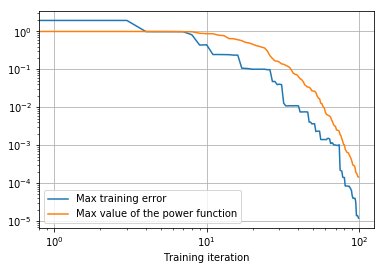

In [7]:
fig = plt.figure(1)
fig.clf()
ax = fig.gca()
ax.loglog(f_max)
ax.loglog(p_max)
ax.set_xlabel('Training iteration')
ax.legend(['Max training error', 'Max value of the power function'])
ax.grid()

Moreover, after the model is trained via the method `fit`, the object `model` stores the coefficients `coef_` and the centers `ctrs_` of the kernel model

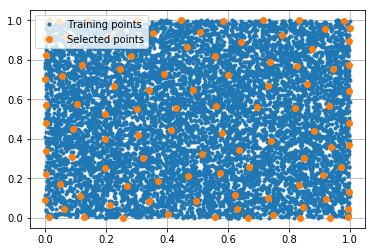

In [8]:
fig = plt.figure(2)
fig.clf()
ax = fig.gca()
ax.plot(X[:, 0], X[:, 1], '.')
ax.plot(model.ctrs_[:, 0], model.ctrs_[:, 1], 'o')
ax.legend(['Training points', 'Selected points'])
ax.grid()


In this case the model was trained with a fixed set of parameters. 
The full set of parameters can be obtained using the `get_params()` method

In [9]:
model.get_params()

{'greedy_type': 'p_greedy',
 'kernel': <kernels.Gaussian at 0x7f2c2921db70>,
 'max_iter': 100,
 'reg_par': 0,
 'restr_par': 0,
 'tol_f': 1e-10,
 'tol_p': 1e-10,
 'verbose': True}

These parameters can be set by the constructor (like we did with `kernel` above) or they can be modified with the `set_params()` method

In [10]:
model.set_params(tol_f=1e-15)

VKOGA(greedy_type='p_greedy',
      kernel=<kernels.Gaussian object at 0x7f2c2921db70>, max_iter=100,
      reg_par=0, restr_par=0, tol_f=1e-15, tol_p=1e-10, verbose=True)

Once a model is trained, it can be used to compute predictions on new input data

In [11]:
s_train = model.predict(X_train)
s_test = model.predict(X_test)

And we can compute some errors

In [12]:
err_train = np.max(np.linalg.norm(s_train - y_train, axis=1))
err_test = np.max(np.linalg.norm(s_test - y_test, axis=1))
print('Training error: %2.2e' % err_train)
print('Test error    : %2.2e' % err_test)

Training error: 3.44e-03
Test error    : 4.51e-03


### Quick usage

All these operations can be condensed also in a single line

In [ ]:
s_test = VKOGA(kernel=kernel).fit(X_train, y_train).predict(X_test)

## Refined training with parameter optimization

The VKOGA models are compatible with scikit-learn interfaces, and in particular their parameters can be optimized with scikit-learn tools.

First, one needs to define a score function to rank the parameters. The following is a simple vectorial version of the `max_error` scorer.

In [13]:
from sklearn.metrics import make_scorer

def vectorial_max_error(y_true, y_pred):
    return np.max(np.sum((y_true - y_pred) ** 2, axis=1))

vectorial_score = make_scorer(vectorial_max_error, greater_is_better=False)

### Deterministic parameter optimization

For a deterministic parameter optimization, we first define a parameter search set

In [14]:
params = {'reg_par': np.logspace(-10, 1, 12)}

Then, we define the VKOGA model as a `GridSearchCV` object. In this case we run a 5-fold cross validation over the parameter set, using all the available cores (`n_jobs=-1`), and refitting the model on the entire training set after the validation is concluded. 

In [15]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(VKOGA(verbose=False), params, scoring=vectorial_score, 
                     n_jobs=-1, cv=5, refit=True, verbose=1)  

The model can be trained as before, but now by additionally running a deterministic cross validation to optimize the specified parameters

In [16]:
model.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   49.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=VKOGA(greedy_type='p_greedy',
                             kernel=<kernels.Gaussian object at 0x7f2c2921d4a8>,
                             max_iter=100, reg_par=0, restr_par=0, tol_f=1e-10,
                             tol_p=1e-10, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'reg_par': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
       1.e-02, 1.e-01, 1.e+00, 1.e+01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(vectorial_max_error, greater_is_better=False),
             verbose=1)

The results of the parameter optimization process can be easily visualized

In [17]:
import pandas as pd
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_par,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.522516,0.146851,0.009940,0.001411,1e-10,{'reg_par': 1e-10},-9.742302e-11,-9.770067e-11,-8.582663e-11,-5.327098e-11,-5.347509e-11,-7.753928e-11,2.019188e-11,1
1,1.893289,0.254333,0.022418,0.018609,1e-09,{'reg_par': 1e-09},-2.634194e-10,-8.209658e-11,-9.131267e-11,-8.461616e-11,-7.801996e-11,-1.198930e-10,7.189304e-11,2
2,3.130064,0.212014,0.020205,0.002421,1e-08,{'reg_par': 1e-08},-1.465481e-09,-5.662515e-10,-8.551401e-10,-6.652381e-10,-6.177595e-10,-8.339741e-10,3.304982e-10,3
3,3.142459,0.157218,0.024708,0.006252,1e-07,{'reg_par': 1e-07},-8.126102e-09,-6.145621e-09,-7.171892e-09,-4.827789e-09,-4.825947e-09,-6.219470e-09,1.298190e-09,4
4,3.293909,0.292993,0.024468,0.007724,1e-06,{'reg_par': 1e-06},-5.937932e-08,-5.521984e-08,-5.639315e-08,-4.750363e-08,-5.870557e-08,-5.544030e-08,4.245590e-09,5
5,3.175856,0.197717,0.018793,0.000744,1e-05,{'reg_par': 1e-05},-4.786579e-07,-4.475211e-07,-4.660615e-07,-5.761079e-07,-4.177208e-07,-4.772139e-07,5.353051e-08,6
6,2.601428,0.115215,0.017681,0.000722,0.0001,{'reg_par': 0.0001},-6.099217e-06,-5.297046e-06,-5.440901e-06,-5.406294e-06,-5.349069e-06,-5.518505e-06,2.944801e-07,7
7,2.735807,0.180960,0.022037,0.004871,0.001,{'reg_par': 0.001},-4.478563e-05,-4.040266e-05,-3.944036e-05,-3.929902e-05,-3.891211e-05,-4.056796e-05,2.165160e-06,8
8,5.162226,1.508919,0.034004,0.010839,0.01,{'reg_par': 0.01},-2.607433e-04,-2.331900e-04,-2.355672e-04,-2.331235e-04,-2.267614e-04,-2.378771e-04,1.180102e-05,9
9,3.316461,0.784151,0.019853,0.002733,0.1,{'reg_par': 0.1},-2.867397e-03,-3.058416e-03,-3.153616e-03,-3.118049e-03,-3.013005e-03,-3.042096e-03,9.983773e-05,10


The trained model can be used as before to compute predictions

In [18]:
s_train = model.predict(X_train)
s_test = model.predict(X_test)
err_train = np.max(np.linalg.norm(s_train - y_train, axis=1))
err_test = np.max(np.linalg.norm(s_test - y_test, axis=1))
print('Training error: %2.2e' % err_train)
print('Test error    : %2.2e' % err_test)

Training error: 7.23e-06
Test error    : 7.18e-06


### Randomized parameter optimization

In this case the parameters are randomly sampled according to some distribution, instead than on a grid.

In [19]:
from utils import log_uniform
        
params = {'reg_par': log_uniform(-10, 1)}

The VKOGA model is now defiened as a `RandomizedSearchCV` object. In addition to the deterministic case, we need also to specify the number of samples to take from the parameter space (`n_iter=12`).

In [20]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomizedSearchCV(VKOGA(verbose=False), params, scoring=vectorial_score, n_iter = 12, 
                           n_jobs=-1, cv=5, refit=True, verbose=1)

Same training (with parameter optimization), parameter inspection and prediction as in the deterministic case

In [21]:
model.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   40.3s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=VKOGA(greedy_type='p_greedy',
                                   kernel=<kernels.Gaussian object at 0x7f2c2921d4a8>,
                                   max_iter=100, reg_par=0, restr_par=0,
                                   tol_f=1e-10, tol_p=1e-10, verbose=False),
                   iid='warn', n_iter=12, n_jobs=-1,
                   param_distributions={'reg_par': <utils.log_uniform object at 0x7f2c29176780>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False,
                   scoring=make_scorer(vectorial_max_error, greater_is_better=False),
                   verbose=1)

In [22]:
pd.DataFrame(model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_par,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.703427,0.103389,0.042586,0.027727,0.524873,{'reg_par': 0.5248726347077696},-8.331453e-03,-7.411532e-03,-7.253004e-03,-7.143552e-03,-7.072220e-03,-7.442352e-03,4.590386e-04,12
1,2.740638,0.141777,0.018699,0.001704,0.0030803,{'reg_par': 0.0030803024171471606},-1.153218e-04,-1.040950e-04,-1.088014e-04,-1.057635e-04,-1.093192e-04,-1.086602e-04,3.848730e-06,10
2,3.083800,0.217324,0.022370,0.005725,1.81345e-06,{'reg_par': 1.813449795647938e-06},-9.736912e-08,-8.999563e-08,-8.818733e-08,-7.773775e-08,-8.021826e-08,-8.670162e-08,7.060285e-09,5
3,3.558590,0.301753,0.022503,0.004287,2.646e-06,{'reg_par': 2.6459973512311116e-06},-1.343426e-07,-1.102081e-07,-1.153499e-07,-1.128879e-07,-1.111478e-07,-1.167872e-07,8.950405e-09,6
4,2.347511,0.412168,0.014440,0.003306,1.02265e-09,{'reg_par': 1.0226463873287985e-09},-2.675136e-10,-8.349983e-11,-9.313865e-11,-8.659506e-11,-7.970713e-11,-1.220909e-10,7.284450e-11,3
5,1.617514,0.206747,0.008759,0.000740,2.29223e-10,{'reg_par': 2.2922349568946977e-10},-1.708062e-10,-8.364846e-11,-7.823668e-11,-9.311726e-11,-8.493586e-11,-1.021489e-10,3.465759e-11,1
6,2.730435,0.040058,0.021885,0.006887,0.355147,{'reg_par': 0.35514671039621876},-6.393607e-03,-6.519135e-03,-6.374636e-03,-6.517888e-03,-6.439792e-03,-6.449011e-03,6.057674e-05,11
7,1.597623,0.209722,0.011144,0.002655,7.04289e-10,{'reg_par': 7.042890070199331e-10},-1.929433e-10,-8.698682e-11,-6.850037e-11,-8.715988e-11,-9.353372e-11,-1.058248e-10,4.435554e-11,2
8,2.448798,0.132624,0.018810,0.001783,1.91474e-09,{'reg_par': 1.9147439288103748e-09},-3.739773e-10,-9.713077e-11,-1.114658e-10,-9.608524e-11,-7.719589e-11,-1.511710e-10,1.119341e-10,4
9,2.929657,0.449378,0.023961,0.010310,0.000518052,{'reg_par': 0.0005180519265921425},-2.554875e-05,-2.305873e-05,-2.280075e-05,-2.369369e-05,-2.255555e-05,-2.353149e-05,1.077553e-06,9


In [23]:
s_train = model.predict(X_train)
s_test = model.predict(X_test)
err_train = np.max(np.linalg.norm(s_train - y_train, axis=1))
err_test = np.max(np.linalg.norm(s_test - y_test, axis=1))
print('Training error: %2.2e' % err_train)
print('Test error    : %2.2e' % err_test)

Training error: 6.21e-06
Test error    : 6.06e-06
